## Missing Data Imputation

We demonstrade in this section an application of our method to impute missing values in experimental data.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import emachine as EM
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

An smoking data was used to illustrate the idea. The data set contains 1536 samples of 38 binary variables.

In [3]:
s0 = np.loadtxt('smoking_data_processed.txt')
print(s0.shape)

(1536, 38)


### Splitting the data into training samples and test samples
We first split the data into 460 training samples and 1076 test samples.

In [4]:
s_train,s_test = train_test_split(s0,test_size=0.7,random_state = 1)
print(s_train.shape,s_test.shape)

#np.savetxt('s_train.dat',s_train,fmt='%i')
#np.savetxt('s_test.dat',s_test,fmt='%i')

(460, 38) (1076, 38)


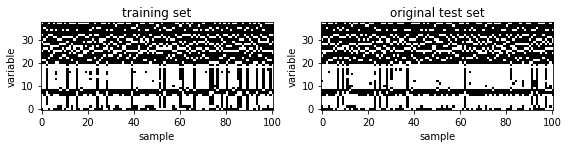

In [5]:
nx,ny = 2,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*4,ny*3.2))

ax[0].set_title('training set')
ax[0].imshow(s_train.T[:,:101],cmap='gray',origin='lower')

ax[1].set_title('original test set')
ax[1].imshow(s_test.T[:,:101],cmap='gray',origin='lower')

for i in range(nx):    
    ax[i].set_xlabel('sample')
    ax[i].set_ylabel('variable')
    ax[i].set_yticks([0,10,20,30])
       
plt.tight_layout(h_pad=0.5, w_pad=0.6)
#plt.savefig('fig1.pdf', format='pdf', dpi=100)

### Inferring the local fiels and pairwise interactions with the training samples
We then apply EM method to predict the local fields `h0` for individual variables and pairwise interactions `w` between variables.

In [6]:
ops = EM.operators(s_train)
print(ops.shape)

(460, 741)


In [7]:
eps_list = np.linspace(0.7,0.9,21)
E_eps = np.zeros(len(eps_list))
w_eps = np.zeros((len(eps_list),ops.shape[1]))
for i,eps in enumerate(eps_list):    
    w_eps[i,:],E_eps[i] = EM.fit(ops,eps=eps,max_iter=100)
    print(eps,E_eps[i])

0.7 -90.97125777628806
0.71 -90.0370848291644
0.72 -89.15520227069703
0.73 -88.32627999469725
0.74 -87.55128825637009
0.75 -86.83153251386894
0.76 -86.16869719480155
0.77 -85.56490097359782
0.78 -85.02276703643429
0.79 -84.54551302868458
0.8 -84.13706706648992
0.81 -83.80221856526629
0.8200000000000001 -83.5468160312931
0.8300000000000001 -83.37802891266647
0.84 -83.30469797326157
0.85 -83.33780984673744
0.86 -83.49114880046875
0.87 -83.7822063148659
0.88 -84.2334739245864
0.89 -84.87431965602296
0.9 -85.74377728370874


Text(0, 0.5, 'Energy')

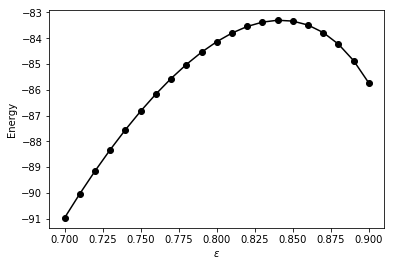

In [8]:
plt.plot(eps_list,E_eps,'ko-')
plt.xlabel('$\epsilon$')
plt.ylabel('Energy')

In [9]:
ieps = np.argmax(E_eps)
print('The optimal value of eps:',eps_list[ieps])

The optimal value of eps: 0.84


So our inferred interactions from EM should be:

In [10]:
w_em = w_eps[ieps]
#np.savetxt('w_em.dat',w_em,fmt='%f')

As the output `w_em` is a combination of local fields `h0` and pairwise interactions `w`, we have to split them for demonstration.

In [11]:
n_var = s_train.shape[1]
h0 = w_em[:n_var]
w1d = w_em[n_var:]

In [12]:
def convert_1d_to_2d(n_var):
    ij2d = np.zeros((n_var,n_var))    
    count = 0
    for i in range(n_var-1):
        for j in range(i+1,n_var):
            ij2d[i,j] = count 
            count += 1           
    return ij2d.astype(int)

ij2d = convert_1d_to_2d(n_var)

In [13]:
w2d = np.zeros((n_var,n_var))
for i in range(0,n_var-1):
    for j in range(i+1,n_var):
        w2d[i,j] = w1d[ij2d[i,j]]

w2d = w2d + w2d.T

The local fieds and interactions are plotted.

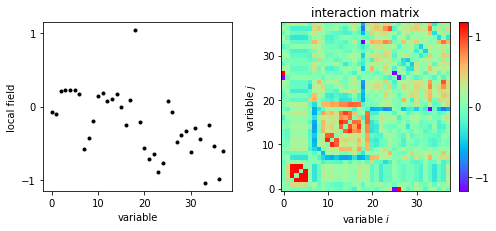

In [14]:
nx,ny = 2,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*3.2))

ax[0].plot(h0,'ko',markersize=3)
ax[0].set_xlabel('variable')
ax[0].set_ylabel('local field')

ax[1].set_title('interaction matrix')
im = ax[1].imshow(w2d,cmap='rainbow',origin='lower')
plt.colorbar(im,ax=ax[1],fraction=0.045, pad=0.05,ticks=[-1.0,0,1.0])
ax[1].set_xlabel('variable $i$')
ax[1].set_ylabel('variable $j$')

ax[0].set_xticks([0,10,20,30])
ax[0].set_yticks([-1,0,1])
ax[1].set_xticks([0,10,20,30])
ax[1].set_yticks([0,10,20,30])

plt.tight_layout(h_pad=0.5, w_pad=0.6)
#plt.savefig('fig1.pdf', format='pdf', dpi=100)

### Imputing missing values of the test samples

To create a nasty test set with missing values from the original test set, we first find unconserved variables.

In [15]:
# find conserved variables
fc = 0.9
l,n = s_test.shape
frequency = [max(np.unique(s_test[:,i], return_counts=True)[1]) for i in range(n)]
cols_conserved = [i for i in range(n) if frequency[i]/float(l) > fc]
print(cols_conserved)

cols_active = np.delete(np.arange(0,n),cols_conserved)
print('number of active variables:',len(cols_active))

[8, 18, 33, 36]
number of active variables: 34


We then randomly select `n_hidden` variables in the test samples and define them as missing values.

In [16]:
n_hidden = 14
s_hidden_all = np.array([])
for t in range(l):
    s = s_test[t].copy()
    hidden = np.random.choice(cols_active,n_hidden,replace=False)       
    s[hidden] = 0
    s_hidden_all = np.vstack([s_hidden_all,s[np.newaxis,:]]) if s_hidden_all.shape[0]>0 else s

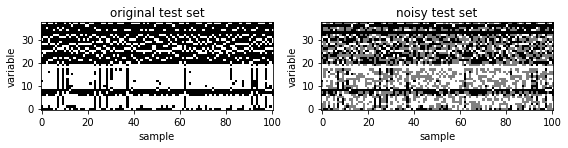

In [17]:
nx,ny = 2,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*4,ny*3.2))

ax[0].set_title('original test set')
ax[0].imshow(s_test.T[:,:101],cmap='gray',origin='lower')

ax[1].set_title('noisy test set')
ax[1].imshow(s_hidden_all.T[:,:101],cmap='gray',origin='lower')

for i in range(nx):    
    ax[i].set_xlabel('sample')
    ax[i].set_ylabel('variable')
    ax[i].set_yticks([0,10,20,30])
       
plt.tight_layout(h_pad=0.5, w_pad=0.6)
#plt.savefig('fig1.pdf', format='pdf', dpi=100)

We now use the predicted local fiels and pairwise interaction from EM method to recover the test set.

In [18]:
# every possibilities of configurations of hiddens
s_hidden_possibles = np.asarray(list(itertools.product([1.0, -1.0], repeat=n_hidden)))
n_possibles = s_hidden_possibles.shape[0]

s_recover_all = np.array([])
acc = np.zeros(l)
# consider each specific sample t:
for t in range(l):
    s = s_hidden_all[t].copy()
    
    hidden = np.where(s==0)[0]    
    s_possibles = np.tile(s,(n_possibles,1))    
    s_possibles[:,hidden] = s_hidden_possibles

    # calculate energy of each possible configuration
    ops = EM.operators(s_possibles)

    #----------------------------------------------
    # recover by EM
    energy = -ops.dot(w_em)
    s_hidden_recover = s_hidden_possibles[np.argmin(energy)]
    
    # recovered accuracy
    acc[t] = np.sum((s_test[t,hidden] == s_hidden_recover))
    #print(acc[t])
    
    # recovered configurations
    s_recover = s.copy()
    s_recover[hidden] = s_hidden_recover
    s_recover_all = np.vstack([s_recover_all,s_recover[np.newaxis,:]]) \
                    if s_recover_all.shape[0]>0 else s_recover
       
acc_av = acc.sum()/(n_hidden*l)
print('Recovered accuracy:',acc_av)

Recovered accuracy: 0.8431359532660648


The recovered data is plotted along with the original data and missing data.

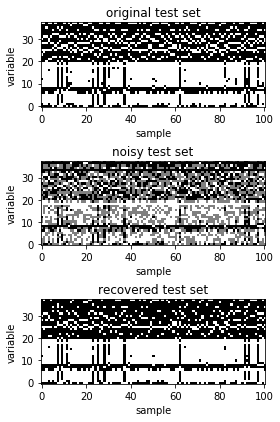

In [19]:
nx,ny = 1,3
fig, ax = plt.subplots(ny,nx,figsize=(nx*4,ny*2.0))

ax[0].set_title('original test set')
ax[0].imshow(s_test.T[:,:101],cmap='gray',origin='lower')

ax[1].set_title('noisy test set')
ax[1].imshow(s_hidden_all.T[:,:101],cmap='gray',origin='lower')

ax[2].set_title('recovered test set')
ax[2].imshow(s_recover_all.T[:,:101],cmap='gray',origin='lower')

for i in range(ny):    
    ax[i].set_xlabel('sample')
    ax[i].set_ylabel('variable')
    ax[i].set_yticks([0,10,20,30])
       
plt.tight_layout(h_pad=0.5, w_pad=0.6)
#plt.savefig('fig2.pdf', format='pdf', dpi=100)

### Performance comparison with PLE

To estimate the performance of EM, we compute tha accuracy for various values of missing variables and compare with the PLE method. This work is performed separately. In the Jupyter Notebook, we just report the result.

In [20]:
acc = np.loadtxt('acc.dat')

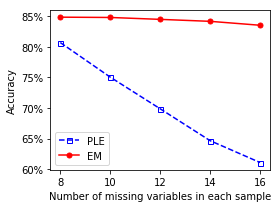

In [21]:
nx,ny = 1,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*4,ny*3.0))

ax.plot(acc[3:,0],acc[3:,2],'bs--',mfc='none',markersize=5,label='PLE')
ax.plot(acc[3:,0],acc[3:,3],'ro-',markersize=5,label='EM')
ax.set_xlabel('Number of missing variables in each sample')
ax.set_ylabel('Accuracy')

ax.set_xticks([8,10,12,14,16])
ax.legend()

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.tight_layout(h_pad=0.5, w_pad=0.6)
#plt.savefig('fig3.pdf', format='pdf', dpi=100)

It is clear that EM works significantly better than PLE. 